In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import math
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import os

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [2]:
data = pd.read_csv('/home/aibig25/hong_sj/trb/num.csv')
data = data.fillna(0)

unique_ids = data['sequence_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=41, random_state=42)
train_data = data[data['sequence_ID'].isin(train_ids)]
test_data = data[data['sequence_ID'].isin(test_ids)]

independent_vars = data.columns.difference(['center_x', 'center_y','center_x_ma','center_y_ma', 'ID', 'frame', "LC"])
dependent_vars = ['center_y_ma']

scaler = MinMaxScaler()

train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
test_data[independent_vars] = scaler.transform(test_data[independent_vars])

X_train = train_data[independent_vars]
y_train = train_data[dependent_vars]

X_test = test_data[independent_vars]
y_test = test_data[dependent_vars]

/tmp/ipykernel_670204/1951914516.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
/tmp/ipykernel_670204/1951914516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[independent_vars] = scaler.transform(test_data[independent_vars])


In [3]:
# 입력 및 예측 시퀀스 길이 정의
input_sequence_length = 120
output_sequence_length = 90

def create_sequences(data, input_sequence_length, output_sequence_length):
    X = []
    y = []

    for i in range(len(data) - input_sequence_length - output_sequence_length + 1):
        X.append(data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        y.append(data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, input_sequence_length, output_sequence_length)
X_test, y_test = create_sequences(test_data, input_sequence_length, output_sequence_length)

In [4]:
# 데이터셋을 텐서로 변환
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [5]:
class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim):
        super(TrajectoryTransformer, self).__init__()
        self.model_dim = model_dim
        
        self.encoder = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        self.tgt_linear = nn.Linear(1, model_dim)  # tgt 차원 변환용 Linear 계층
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=0.1),
            num_layers=num_encoder_layers
        )
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=0.1),
            num_layers=num_decoder_layers
        )
        
        self.decoder = nn.Linear(model_dim, output_dim)

    def forward(self, src, tgt):
        src = self.encoder(src)
        src = src * math.sqrt(self.model_dim)
        src = self.pos_encoder(src.permute(1, 0, 2))

        tgt = tgt.squeeze(-1)  # 마지막 차원 제거
        original_shape = tgt.shape
        tgt = tgt.reshape(-1, 1)  # view 대신 reshape 사용 (batch_size * seq_length, 1)
        tgt = self.tgt_linear(tgt)  # 차원 조정
        tgt = tgt.view(original_shape[0], original_shape[1], -1)  # 원래 차원으로 복원
        tgt = tgt * math.sqrt(self.model_dim)
        tgt = self.pos_encoder(tgt.permute(1, 0, 2))

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.decoder(output.permute(1, 0, 2))

        # 첫 번째 Transformer Encoder Layer의 Attention Weights 추출
        attn_layer = self.transformer_encoder.layers[0].self_attn
        attn_output, attn_weights = attn_layer(src, src, src)

        return output, attn_weights

# 위치 인코딩 추가
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [6]:
# 모델 초기화
input_dim = len(independent_vars)
output_dim = len(dependent_vars)
model_dim = 512
num_heads = 4
num_encoder_layers = 3
num_decoder_layers = 3

model = TrajectoryTransformer(input_dim, model_dim, num_heads, num_encoder_layers, num_decoder_layers, output_dim)

# 옵티마이저와 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [7]:
# 예시 입력 데이터 (배치 크기: 1, 시간 단계: 120, 변수: 24)
example_src = torch.tensor(X_train[:1], dtype=torch.float32)
example_tgt = torch.tensor(y_train[:1], dtype=torch.float32)

In [8]:
# 모델 실행
model.eval()
with torch.no_grad():
    output, attention_weights = model(example_src, example_tgt)

In [9]:
# Attention Weights 시각화
variable_names = independent_vars.tolist()
# 하나의 head 선택 (예: 첫 번째 head)
attention_weights_np = attention_weights[0, :, :].detach().numpy()  # (seq_len, seq_len)

# X축: 시간 (120개의 시간 단계)
time_steps = np.arange(1, 121)

# Y축: 입력 변수 (24개의 변수)
variables = [f'Variable {i+1}' for i in range(25)]

# Attention Weights 중 일부만 선택하여 시각화 (24개의 입력 변수에 해당하는 부분만 선택)
# attention_weights_np = attention_weights_np[:25, :120]

attention_weights_np = attention_weights_np[:120, :25].T


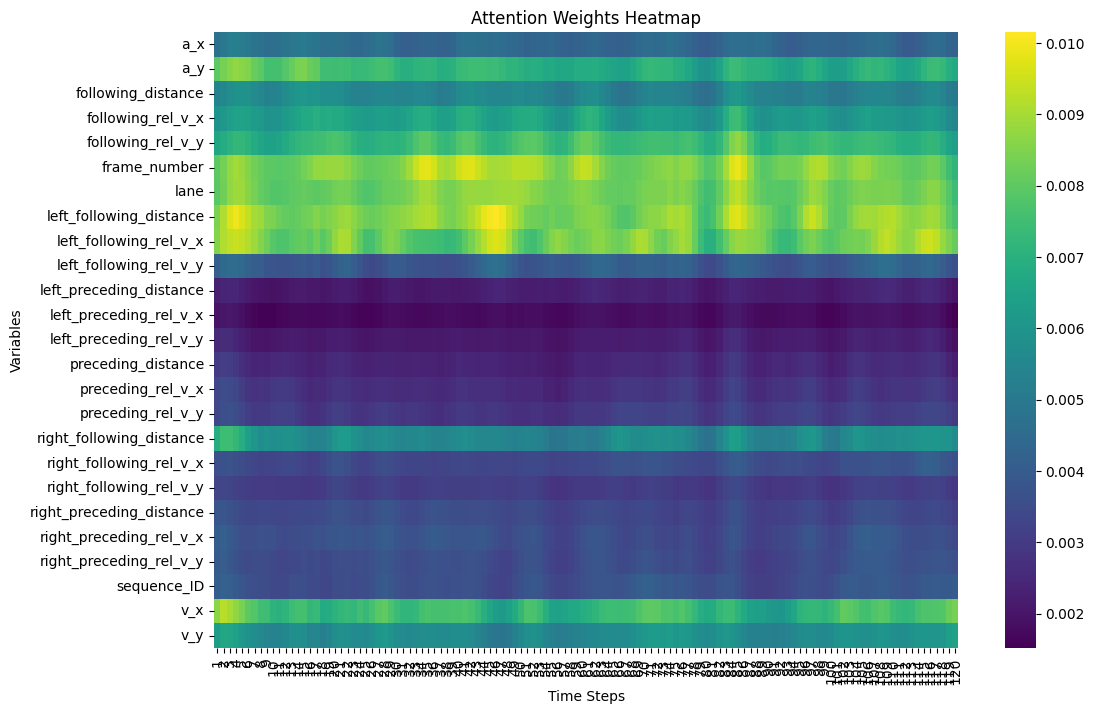

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(attention_weights_np, xticklabels=time_steps, yticklabels=variable_names, cmap='viridis')
plt.xlabel('Time Steps')
plt.ylabel('Variables')
plt.title('Attention Weights Heatmap')
plt.show()

In [11]:
# Time Step 1의 Attention Weights 추출
time_step_1_weights = attention_weights_np[:, 0]

# 중요한 변수들 (Attention Weight 기준으로 상위 5개 변수 선택)
important_variables_indices = np.argsort(time_step_1_weights)[-5:][::-1]
important_variables = [variable_names[i] for i in important_variables_indices]

# 중요한 변수와 그들의 Attention Weight 출력
for i, var in zip(important_variables_indices, important_variables):
    print(f'Variable {var}: Attention Weight {time_step_1_weights[i]}')

Variable v_x: Attention Weight 0.008635427802801132
Variable left_following_rel_v_x: Attention Weight 0.008552057668566704
Variable left_following_distance: Attention Weight 0.008462268859148026
Variable frame_number: Attention Weight 0.007970744743943214
Variable a_y: Attention Weight 0.007960861548781395
